In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
posts = "data//facebook_congress_posts.csv"
responses = "data//facebook_congress_responses.csv"

In [3]:
postsDf = pd.read_csv(posts)

In [4]:
responsesDf = pd.read_csv(responses)

## Basic value counts

In [5]:
postsDf.head()

,op_id,op_gender,post_id,post_text,post_type
0,57265377,M,0,"Yesterday, my colleagues and I voted to protec...",video
1,57265377,M,1,Roses are red...and so is Texas. Let's keep it...,video
2,57265377,M,2,#TBT to this classic video. #DonkeyWhisperer,video
3,57265377,M,3,Since President Donald J. Trump was sworn in o...,video
4,57265377,M,4,Remembering our 40th president today. LIKE to ...,video


In [8]:
# this is the number of unique posts
# not all the posts necessarily have responses 
postsDf['post_id'].nunique()

548341

In [9]:
#occurrences of each post type
postsDf['post_type'].value_counts()

link      210499
photo     199123
status     87921
video      46842
event       3417
music        278
note         261
Name: post_type, dtype: int64

In [10]:
responsesDf.head()

,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category
0,57265377,M,0,Jerry,Protecting birth is not the same as protecting...,Roger Williams,Congress_Republican
1,57265377,M,0,Andrea,You need to protect children and leave my body...,Roger Williams,Congress_Republican
2,57265377,M,0,Sherry,Thank you,Roger Williams,Congress_Republican
3,57265377,M,0,Bob,Thank you Roger,Roger Williams,Congress_Republican
4,57265377,M,0,Joy,Unwanted pregnancy is a sad and unfortunate si...,Roger Williams,Congress_Republican


In [11]:
responsesDf.shape

(13866507, 7)

In [14]:
#number of unique congress members 
len(responsesDf['op_id'].unique())

402

In [16]:
# number of male and female congresspeople in the data set 
unique_congresspeople = responsesDf.drop_duplicates('op_name')
unique_congresspeople.op_gender.value_counts()

M    306
W     96
Name: op_gender, dtype: int64

In [17]:
# TODO: change this merge so that we ONLY get the names, not all the other stuff 
unique_congresspeople = unique_congresspeople.filter(items=['op_name', 'op_id'])
postsDf = postsDf.merge(unique_congresspeople, how='left', on='op_id')
grouped_posts = postsDf.groupby('op_id')

In [18]:
# gut check to be sure every op_id just lines up with one name
# it looks like none of them have more than 1 name, but 5 of them are missing a name?
# that seems like it needs to be cleaned up 
test = grouped_posts['op_name'].nunique()
print(max(test))
print(min(test))
print(len([x for x in test if x==0]))

1
0
5


In [23]:
# this shows us that there are 5 more congressperson groups than we had names 
len(grouped_posts)

407

### Cells for exploring unnamed congresspeople

In [25]:
postsDf[postsDf['op_name'].isnull()].op_id.value_counts()

42721680    2447
44922372    1520
54138093    1143
96418867     100
58288189       1
Name: op_id, dtype: int64

In [54]:
# googling some of these and playing around helped me figure out that one of the blank ids is Scott Tipton
# we can probably use google to figure out the other ones too

print(postsDf[postsDf['op_id']==42721680]['post_text'][224602])
# according to Google, this was said by Scott Tipton

print("\n" + postsDf[postsDf['op_id']==44922372]['post_text'][508441])
# according to Google, this was said by Martin Heinrich

print("\n" + postsDf[postsDf['op_id']==54138093]['post_text'][260136])
# according to Google, this was said by Mac Thornberry

print("\n" + postsDf[postsDf['op_id']==96418867]['post_text'][511455])
# according to Google, this was said by Darren Soto

print("\n" + postsDf[postsDf['op_id']==58288189]['post_text'][466543])
# this one doesn't really seem like it was said by a real congressperson
# we should remove it from the set

Our veterans answered the call to serve our country, and when they return home it is our duty to serve them. The HIRE Vets Act and BRAVE Act will help us fulfill this commitment.

Access to Medicaid is making a difference for New Mexicans like Elena. Read her story here:

This evening, the House passed an important bill for our part of Texas and private landowners everywhere. The bill known as the "Red River Gradient Boundary Survey Act," H.R. 428, which I introduced earlier this year, passed by a vote of 250-171.   This bill essentially requires the BLM to do what it should have done all along by establishing a fair and balanced process to conduct an accurate survey of contested land along the Red River to find the proper boundary between public and private ownership. Private property owners should never have to worry about the federal government coming in and taking away their land, especially land that has never been properly surveyed.   I will continue working with the landowners, 

In [60]:
# confirm that none of the congress people we just identified are already in the original set
all_congress_names = unique_congresspeople.op_name.values
no_matches_found = True
for name in ['Tipton', 'Thornberry', 'Heinrich', 'Soto']:
    for confirmed_name in all_congress_names:
        if name in confirmed_name:
            print("Match found: {} and {}".format(name, confirmed_name))
            no_matches_found = False
if no_matches_found:
    print("no matches found!")

no matches found!


In [65]:
# add in all the correct names
postsDf.loc[postsDf.op_id==42721680, 'op_name'] = 'Scott Tipton'
postsDf.loc[postsDf.op_id==44922372, 'op_name'] = 'Martin Heinrich'
postsDf.loc[postsDf.op_id==54138093, 'op_name'] = 'Mac Thornberry'
postsDf.loc[postsDf.op_id==96418867, 'op_name'] = 'Darren Soto'

In [66]:
# confirm - there should just be one now
postsDf[postsDf['op_name'].isnull()]

,op_id,op_gender,post_id,post_text,post_type,op_name
466543,58288189,M,466543,My husband John and I (Muellerleile) are hosti...,status,NaN


In [68]:
# drop the one
print(postsDf.shape)
postsDf = postsDf[~postsDf['op_name'].isnull()]
print(postsDf.shape)

(548341, 6)
(548340, 6)


In [69]:
# remake the grouped df with these changes 
# there should be 406 groups now 
grouped_posts = postsDf.groupby('op_id')
len(grouped_posts)

406

In [105]:
# make separate male and female grouped posts dfs
f_grouped_posts=postsDf[postsDf['op_gender']=='W'].groupby('op_id')
print(len(f_grouped_posts))
m_grouped_posts=postsDf[postsDf['op_gender']=='M'].groupby('op_id')
len(m_grouped_posts)

96


310

## Overall Distributions

### Number of Posts per Congress Member

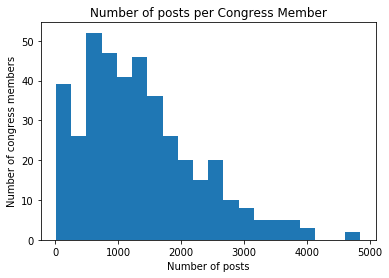

count     406.000000
mean     1350.591133
std       932.502864
min         9.000000
25%       639.250000
50%      1211.000000
75%      1855.250000
max      4853.000000
dtype: float64

In [84]:
# distribution of number of posts per congress person
plt.hist(grouped_posts.size(), bins=20)
plt.xlabel("Number of posts")
plt.ylabel("Number of congress members")
plt.title("Number of posts per Congress Member")
plt.show()

grouped_posts.size().describe()

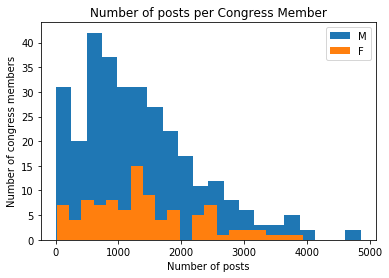

In [110]:
plt.hist(m_grouped_posts.size(), bins=20, label='M')
plt.hist(f_grouped_posts.size(), bins=20, label='F')
plt.legend()
plt.xlabel("Number of posts")
plt.ylabel("Number of congress members")
plt.title("Number of posts per Congress Member")
plt.show()

In [117]:
print("Male:\n") 
print(m_grouped_posts.size().describe())
print("\nFemale:\n")
print(f_grouped_posts.size().describe())

Male:

count     310.000000
mean     1332.290323
std       940.403139
min         9.000000
25%       628.000000
50%      1170.500000
75%      1845.750000
max      4853.000000
dtype: float64

Female:

count      96.000000
mean     1409.687500
std       908.826361
min        15.000000
25%       736.250000
50%      1289.000000
75%      1937.000000
max      3939.000000
dtype: float64


**Finding**: While there are more male than female congresspeople, men and women have around the same number of posts on average, and the distributions of number of posts look pretty similar for men and women. 

### Number of Words Per Post

In [118]:
# distribution of word counts of congresspeople's posts
## TODO: make tokenization a little better here
def get_word_count(row):
    post = str(row['post_text'])
    return len(post.split())

postsDf['word_count'] = postsDf.apply(get_word_count, axis=1)

count    548340.000000
mean         39.992273
std          46.621883
min           1.000000
25%          16.000000
50%          28.000000
75%          51.000000
max        3080.000000
Name: word_count, dtype: float64

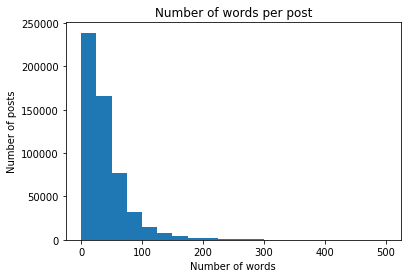

In [119]:
#various views of post distribution 
plt.hist(postsDf['word_count'], range=(0,500), bins=20)
plt.xlabel("Number of words")
plt.ylabel("Number of posts")
plt.title("Number of words per post")

postsDf['word_count'].describe()

Text(0.5, 1.0, 'Number of words per post')

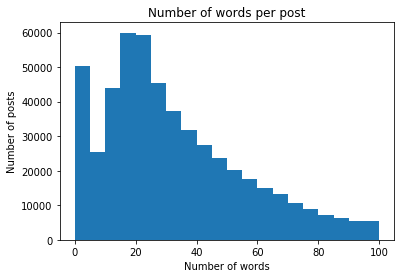

In [120]:
# very skewed data set. even though max is 3000ish, 
# most of the data is in this plot 
plt.hist(postsDf['word_count'], range=(0,100), bins=20)
plt.xlabel("Number of words")
plt.ylabel("Number of posts")
plt.title("Number of words per post")

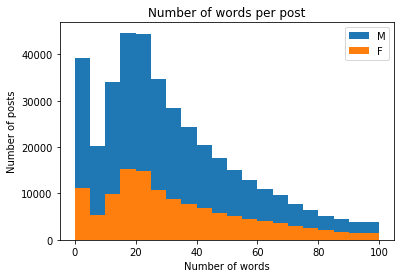

In [127]:
plt.hist(postsDf[postsDf.op_gender=='M']['word_count'], range=(0,100), bins=20, label='M')
plt.hist(postsDf[postsDf.op_gender=='W']['word_count'], range=(0,100), bins=20, label='F')
plt.legend()
plt.xlabel("Number of words")
plt.ylabel("Number of posts")
plt.title("Number of words per post")
plt.show()

In [130]:
print("Male:\n") 
print(postsDf[postsDf.op_gender=='M']['word_count'].describe())
print("\nFemale:\n")
print(postsDf[postsDf.op_gender=='W']['word_count'].describe())

Male:

count    413010.000000
mean         39.314900
std          46.849277
min           1.000000
25%          16.000000
50%          28.000000
75%          50.000000
max        3080.000000
Name: word_count, dtype: float64

Female:

count    135330.000000
mean         42.059529
std          45.859294
min           1.000000
25%          17.000000
50%          30.000000
75%          55.000000
max        1989.000000
Name: word_count, dtype: float64


**Finding**: While there are more male than female congresspeople, men and women have around the same average post word length, and the distributions of post word lengths look pretty similar for men and women. 

In [121]:
## number of posts with 1 word, and other common numbers of words
postsDf['word_count'].value_counts()[:10]

1     43861
19    12771
20    12733
18    12678
21    12606
17    12087
22    11894
16    11496
23    11377
15    10921
Name: word_count, dtype: int64

In [122]:
# exploration of the 1-word posts: many are NaN (presumably they only have a video, or some other media)
# some are hashtags or links 
postsDf[postsDf['word_count']==1]['post_text'].value_counts(dropna=False)

NaN                                                                                                                                                                                 38206
»                                                                                                                                                                                     162
ICYMI                                                                                                                                                                                  20
http://majorityleader.gov/floor/weekly.html                                                                                                                                            17
#NeverForget                                                                                                                                                                           14
ICYMI:                                                                

### Number of Responses Per Post

In [139]:
responses_grouped_by_post = responsesDf.groupby('post_id')

In [195]:
m_responses_grouped_by_post = responsesDf[responsesDf['op_gender']=='M'].groupby('post_id')
f_responses_grouped_by_post = responsesDf[responsesDf['op_gender']=='W'].groupby('post_id')

Text(0.5, 1.0, 'Number of responses per post')

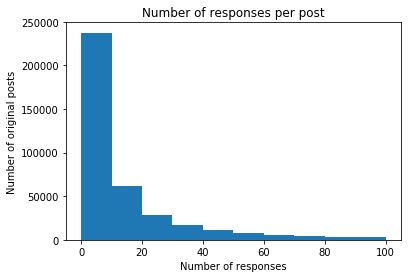

In [196]:
plt.hist(responses_grouped_by_post.size(), range=(0,100))
plt.xlabel("Number of responses")
plt.ylabel("Number of original posts")
plt.title("Number of responses per post")

In [143]:
# there are relatively few responses per post, with a long tail 
# (standard deviation is way higher than the mean )
responses_grouped_by_post.size().describe()

count    399037.000000
mean         34.749928
std         352.767084
min           1.000000
25%           2.000000
50%           6.000000
75%          20.000000
max      157366.000000
dtype: float64

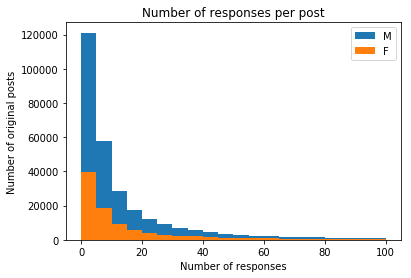

In [197]:
plt.hist(m_responses_grouped_by_post.size(), range=(0,100), bins=20, label='M')
plt.hist(f_responses_grouped_by_post.size(), range=(0,100), bins=20, label='F')
plt.legend()
plt.xlabel("Number of responses")
plt.ylabel("Number of original posts")
plt.title("Number of responses per post")
plt.show()

In [199]:
print("Male:\n")
print(m_responses_grouped_by_post.size().describe())
print("\nFemale:\n")
print(f_responses_grouped_by_post.size().describe())

Male:

count    299324.000000
mean         34.769267
std         373.354449
min           1.000000
25%           2.000000
50%           6.000000
75%          19.000000
max      157366.000000
dtype: float64

Female:

count    99713.000000
mean        34.691876
std        282.083385
min          1.000000
25%          2.000000
50%          7.000000
75%         21.000000
max      59020.000000
dtype: float64


**Findings**: Once again, remarkable parity between men and women here in terms of the distribution of number of responses per post. 

In [173]:
posts_w_number_responses = responses_grouped_by_post.size().reset_index()
posts_w_number_responses.columns = ['post_id', 'num_responses']
posts_w_number_responses = posts_w_number_responses.merge(postsDf, how='left', on='post_id')
posts_w_number_responses.head()

,post_id,num_responses,op_id,op_gender,post_text,post_type,op_name,word_count
0,0,13,57265377,M,"Yesterday, my colleagues and I voted to protec...",video,Roger Williams,32
1,1,30,57265377,M,Roses are red...and so is Texas. Let's keep it...,video,Roger Williams,15
2,2,37,57265377,M,#TBT to this classic video. #DonkeyWhisperer,video,Roger Williams,6
3,3,118,57265377,M,Since President Donald J. Trump was sworn in o...,video,Roger Williams,59
4,4,9,57265377,M,Remembering our 40th president today. LIKE to ...,video,Roger Williams,15


In [192]:
print("Total number of posts w/ any responses: {}".format(len(posts_w_number_responses)))

def print_posts_with_n_responses(n):
    posts_w_n_responses = posts_w_number_responses[posts_w_number_responses['num_responses'] > n]
    print("\nNumber of posts w/ > {} responses: {} ({:.4f})".format(n, len(posts_w_n_responses), len(posts_w_n_responses) / len(posts_w_number_responses)))
    print("Number of congress people with at least one post above > {} responses: {}".format(n, posts_w_n_responses.op_name.nunique()))
    print("Top 10:\n {}".format(posts_w_n_responses.op_name.value_counts()[:10]))
    return posts_w_n_responses
    
posts_w_100_r = print_posts_with_n_responses(100)
posts_w_1000_r = print_posts_with_n_responses(1000)
posts_w_10000_r = print_posts_with_n_responses(10000)
    

Total number of posts w/ any responses: 399037

Number of posts w/ > 100 responses: 21278 (0.0533)
Number of congress people with at least one post above > 100 responses: 359
Top 10:
 Rand Paul           1935
Marco Rubio         1185
Darrell Issa         759
Elizabeth Warren     667
Nancy Pelosi         476
John McCain          458
Al Franken           454
Tom Cotton           429
Patty Murray         406
Lindsey Graham       404
Name: op_name, dtype: int64

Number of posts w/ > 1000 responses: 1512 (0.0038)
Number of congress people with at least one post above > 1000 responses: 126
Top 10:
 Rand Paul           309
Elizabeth Warren    197
Trey Gowdy          179
Marco Rubio         114
John McCain          48
Bernie Sanders       47
Cory Booker          41
Mia Love             41
Al Franken           32
Nancy Pelosi         28
Name: op_name, dtype: int64

Number of posts w/ > 10000 responses: 29 (0.0001)
Number of congress people with at least one post above > 10000 responses: 17
Top 

In [202]:
# the big-response posts are normally from well-known congress members, 
# plus they are talking about controversial topics (Trump, Betsy DeVos, Israel, Clinton, immigration)
# idk what to make of the #FridayPuppy stuff 

for i in range(29):
    print(posts_w_10000_r.iloc[i]['op_name'] + ": " + posts_w_10000_r.iloc[i]['post_text'] + "\n")

Roger Williams: Join me in wishing President Bush a Happy Birthday!

Rand Paul: Help send the White House a message.  Comment with "No Authority!" and SHARE if you agree with me that President Obama has no legal right to issue executive amnesty!

Rand Paul: Let me know if you think Congress should depose Hillary Clinton about the attack on our consulate in Benghazi by taking the survey below.  LIKE and SHARE.     http://www.rand-2016.com/testify.aspx?pid=0813f

Paul Ryan: Here's my full statement on Hillary Clinton in light of the FBI's announcement today:  Regardless of this decision, the undisputed finding of the FBI's investigation is that Secretary Clinton put our nation's secrets at risk and in doing so compromised our national security. She simply believes she's above the law and always plays by her own rules. This is a pattern with the Clintons, and the American people should not have to endure four more years of their scandal and baggage. Fortunately, the American people have t

### Lengths of Responses

In [ ]:
# distribution of word counts of congresspeople's posts
## TODO: make tokenization a little better here
def get_words(row):
    post = str(row['response_text'])
    return post.split()

def get_word_count(row):
    return len(row['words'])

responsesDf['words'] = responsesDf.apply(get_words, axis=1)
responsesDf['word_counts'] = responsesDf.apply(get_word_count, axis=1)

In [ ]:
# TODO: tf-idf

## Annotations

In [ ]:
annotations = "rtgender//annotations.csv"

In [ ]:
annotationsDf = pd.read_csv(annotations)

In [ ]:
annotationsDf = annotationsDf[annotationsDf['source']=='facebook_congress']

In [ ]:
annotationsDf.head()

In [ ]:
annotationsDf.sentiment.value_counts()

In [ ]:
annotationsDf.relevance.value_counts()